In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Read data
app_train = pd.read_csv("data/credits.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Iterate through the columns to encode features
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            le = LabelEncoder()
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
# Split data
X = app_train.drop(["TARGET"], axis=1)
y = app_train["TARGET"].to_numpy()
# one-hot encoding of categorical variables
X = pd.get_dummies(X)

features = X.columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Transform  training data
X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

# Balancing data
X_0 = X[y == 0]
X_1 = X[y == 1]
y_0 = y[y == 0]
y_1 = y[y == 1]
X_0 = X_0[0:X_1.shape[0], :]
y_0 = y_0[0:X_1.shape[0]]
X = np.vstack([X_0, X_1])
y = np.hstack([y_0, y_1])
# Train test split data and convert to pytorch's tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Size of training data: {X_train.shape}. Testing data {X_test.shape}")

Size of training data: (39720, 242). Testing data (9930, 242)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validation(X, y):
    '''
    K-Folds Cross-Validation
    '''
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    results = []
    for train_index, test_index in kf.split(X):
        classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
        _X_train, _X_test = X[train_index], X[test_index]
        _y_train, _y_test = y[train_index], y[test_index]
        classifier.fit(_X_train, _y_train)
        y_hat = classifier.predict(_X_test)
        results.append(accuracy_score(_y_test, y_hat))
        
    return np.mean(results), np.std(results)

results = cross_validation(X_train, y_train)
print(f"Cross validation on training with Accuracy of {results[0]} ± {results[1]}")

Cross validation on training with Accuracy of 0.9557905337361532 ± 0.002765262883735354


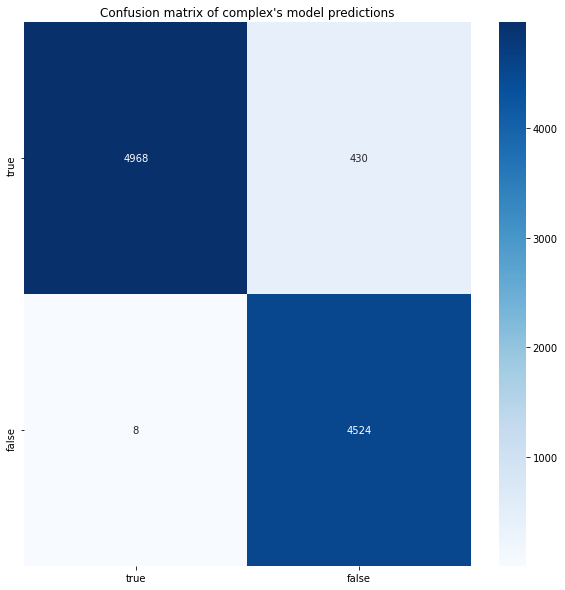

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
classifier.fit(X_train, y_train)
validation = confusion_matrix(classifier.predict(X_test), y_test)
df_cm = pd.DataFrame(validation, index = ["true", "false"],
                  columns = ["true", "false"])

plt.figure(figsize=(10, 10))
plt.title("Confusion matrix of complex's model predictions")
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g') 
plt.show()

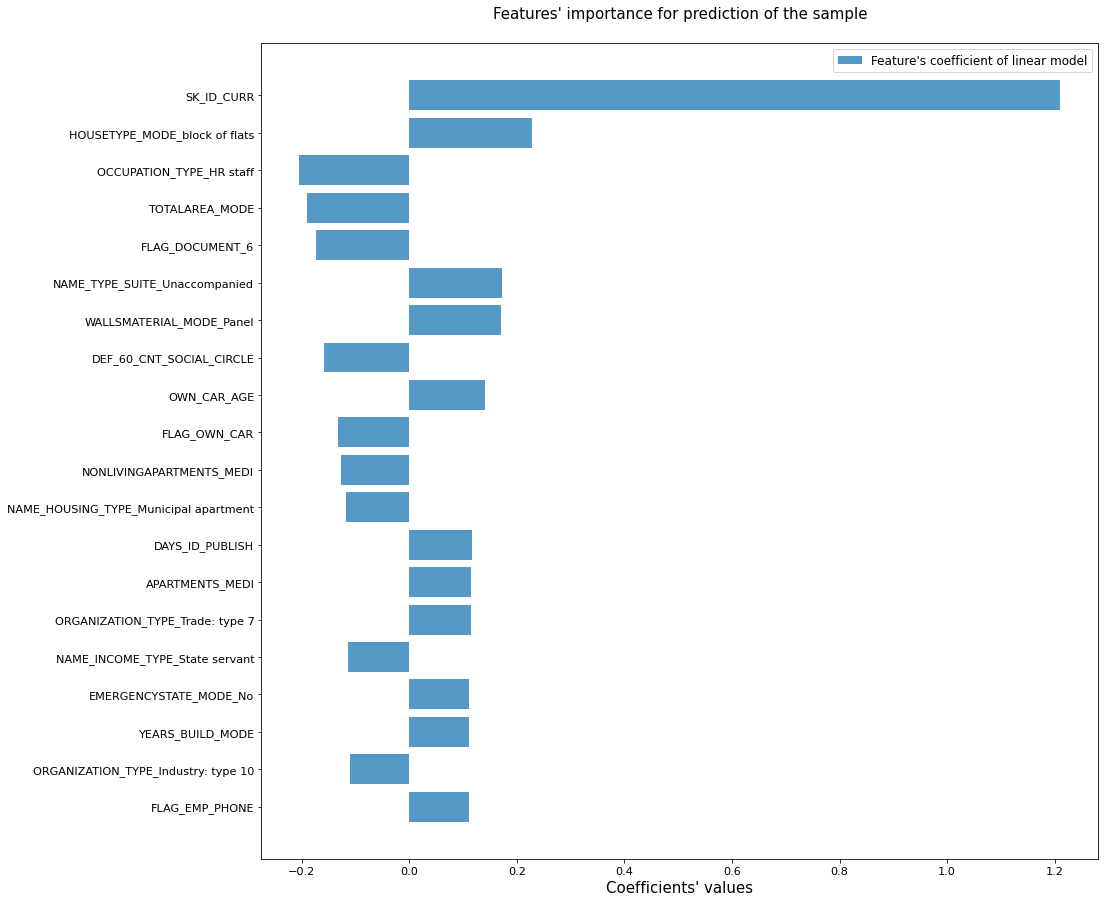

In [5]:
from sklearn.linear_model import LogisticRegression 

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def lime(x, f, N, variance):
    covariance_matrix = np.identity(x.shape[0]) * variance
    # take sample from multivariate gauss 
    x_equiv = np.random.multivariate_normal(mean=x, cov=covariance_matrix, size=N)
    # Predict sample with the complex model
    y_hat = f.predict(x_equiv).astype(np.float64).reshape(x_equiv.shape[0])
    # Fit simple model with input x and prediction y_hat of complex model
    model = LogisticRegression(solver='saga', fit_intercept=False, random_state=42, max_iter=1000)
    model.fit(x_equiv, y_hat)
    # Return simple's model parameters
    return list(zip(list(model.coef_[0, :]), list(features)))

# Pick a sample from test dataset
sample = X_test[1, :]

linear_model = lime(sample, classifier, 1000, 10)
linear_model = sorted(linear_model, key=lambda item: np.abs(item[0]), reverse=True)[:20]
coefs = [feature[0] for feature in linear_model][::-1]
names = [feature[1] for feature in linear_model][::-1]

plt.figure(figsize=(15, 15))
plt.title("Features' importance for prediction of the sample")
plt.barh(names, coefs, label="Feature's coefficient of linear model", alpha=0.75)
plt.xlabel("Coefficients' values")
plt.legend()
plt.rcParams['axes.facecolor'] = 'red'
plt.rcParams['savefig.facecolor'] = 'white'
plt.savefig("output.png")
plt.show()

In [78]:
from scipy import stats 
models = []

for i in range(0, 100):
    linear_model = lime(sample, classifier, 1000, 10)
    coefs = [feature[0] for feature in linear_model]
    models.append(coefs)
    
stats.f_oneway(*models)

F_onewayResult(statistic=0.42977049702267733, pvalue=0.9999998728951593)